### Introduction

In [16]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

store_sales = pd.read_csv(
    'C:\\Users\\Genos\\Projeler\\Python İle Makine Öğrenmesi\\Projeler\\Store Sales\\datasets\\train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
        .loc['2017']
)

test = pd.read_csv(
    'C:\\Users\\Genos\\Projeler\\Python İle Makine Öğrenmesi\\Projeler\\Store Sales\\datasets\\test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

Aşağıdaki üç tahmin görevini göz önünde bulundurun:

a. 3-step forecast using 4 lag features with a 2-step lead time<br>
b. 1-step forecast using 3 lag features with a 1-step lead time<br>
c. 3-step forecast using 4 lag features with a 1-step lead time<br>

Her biri yukarıdaki görevlerden birini temsil eden üç veri kümesini görmek için sonraki hücreyi çalıştırın.

In [17]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

### 1) Match description to dataset (Açıklamayı veri kümesiyle eşleştirin)

Her görevi uygun veri kümesiyle eşleştirebilir misiniz?

In [18]:
# YOUR CODE HERE: Match the task to the dataset. Answer 1, 2, or 3.
task_a = 2
task_b = 1
task_c = 3

Eğitim ve test setlerinin zaman indekslerine bakın. Bu bilgilerden, Mağaza Satışları için tahmin görevini tanımlayabilir misiniz?

In [19]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

### 2) Mağaza Satışları yarışması için tahmin görevini belirleyin (Identify the forecasting task for Store Sales competition)

Forecast origin ve forecast horizon belirlemeye çalışın. Forcast horizon kaç adım var? Forecast için lead time nedir?


Eğitim seti 2017-08-15'te sona eriyor ve bu da bize forecast origin veriyor. Test seti 2017-08-16 ile 2017-08-31 tarihlerini kapsar ve bu bize forecast horizon verir. Origin ve horizon arasında bir adım var, bu yüzden bir günlük lead time var.
Başka bir deyişle, 1 adımlı lead time olan 16 adımlı bir forecast'e (tahmine) ihtiyacımız var. Gecikme 1 ile başlayan gecikmeleri kullanabiliriz ve 2017-08-15 arasındaki özellikleri kullanarak 16 adımlı tahminin tamamını yaparız.


Eğitimde, tek bir zaman serisi için çok adımlı bir veri kümesinin nasıl oluşturulacağını gördük. Neyse ki, birden fazla serinin veri kümeleri için tamamen aynı prosedürü kullanabiliriz.

### 3) Mağaza Satışları için çok adımlı veri seti oluşturun (Create multistep dataset for Store Sales)

Mağaza Satışları tahmini görevine uygun hedefler oluşturun. 4 günlük lag özelliklerini kullanın. Hem hedeflerden hem de özelliklerden eksik değerleri çıkartın.

In [20]:
# YOUR CODE HERE
y = family_sales.loc[:, 'sales']

# YOUR CODE HERE: Make 4 lag features
X = make_lags(y, lags=4).dropna()

# YOUR CODE HERE: Make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

Eğiticide, Flu Trends serisindeki MultiOutput ve Direct stratejileriyle nasıl tahmin yapılacağını gördük. Şimdi DirRec stratejisini Mağaza Satışlarının birden çok zaman serisine uygulayacaksınız.

Önceki alıştırmayı başarıyla tamamladığınızdan emin olun ve ardından verileri XGBoost için hazırlamak için bu hücreyi çalıştırın.

In [21]:
le = LabelEncoder()
X = (X
     .stack('family')  # wide to long
     .reset_index('family')  # convert index to column
     .assign(family=lambda x: le.fit_transform(x.family))  # label encode
     )
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

### 4) DirRec stratejisiyle tahmin (Forecast with the DirRec strategy)

DirRec stratejisini XGBoost'a uygulayan bir model kurun.

In [22]:
from sklearn.multioutput import RegressorChain

# YOUR CODE HERE
model = RegressorChain(base_estimator=XGBRegressor())

In [23]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

Ve bu modelin eğitim verileri üzerinde yaptığı 16 adımlı tahminlerin bir örneğini görmek için bu kodu kullanın.

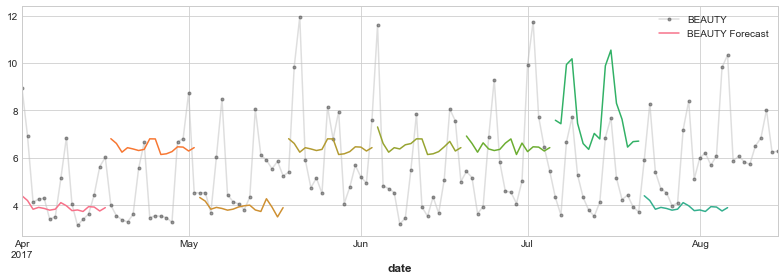

In [24]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [25]:
y_pred

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.706484     6.588345     7.489037   
           BABY CARE                      0.945634     1.420450     1.106641   
           BEAUTY                         6.706484     6.588345     7.489037   
           BEVERAGES                   3262.328613  3507.129395  4851.775879   
           BOOKS                          1.168675     1.420450     1.106641   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      345.968353   339.211426   352.909332   
           PREPARED FOODS                98.439781   107.795624   104.425468   
           PRODUCE                     2222.561035  2357.666748  3117.094238   
           SCHOOL AND OFFICE SUPPLIES    30.678667    27.590700    25.955845   
           SEAFOOD                       22.902594    25.144455    22.450832   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.631713     7.686126     6.872079   
           BABY CARE                      1.412934     0.911818     1.030322   
           BEAUTY                         7.386412     7.686126     6.872079   
           BEVERAGES                   5490.772949  3439.650879  3164.806641   
           BOOKS                          1.412934     0.911818     1.030322   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      319.742065   546.124817   442.962830   
           PREPARED FOODS                84.917015    83.274704    99.409241   
           PRODUCE                     1702.226318  2024.906860  2297.686768   
           SCHOOL AND OFFICE SUPPLIES    20.388109    14.614511    21.536602   
           SEAFOOD                       17.910196    22.349632    24.095694   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.600883     6.618326     6.796880   
           BABY CARE                      0.990770     1.474051     1.755131   
           BEAUTY                         6.600883     6.800453     6.796880   
           BEVERAGES                   3051.604980  2790.089600  3221.736084   
           BOOKS                          1.109941     1.474051     1.755131   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      468.727417   347.168243   320.476807   
           PREPARED FOODS               101.837982   101.290146   103.413254   
           PRODUCE                     2894.276611  2089.364746  2049.405518   
           SCHOOL AND OFFICE SUPPLIES    32.804363    29.191860    26.184706   
           SEAFOOD                       25.357210    25.896801    26.463980   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.139919     6.621857     6.541267   
           BABY CARE                      1.427863     1.460183     1.483901   
           BEAUTY                         6.139919     6.621857     6.541267   
           BEVERAGES                   4674.974121  5587.095215  3782.173096   
           BOOKS                          1.427863     1.460183     1.483901   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      322.663940   290.080231   538.398560   
           PREPARED FOODS               101.597092    83.801720    83.925331   
           PRODUCE                     2727.199951  1735.701050  2222.351807   
           SCHOOL AND OFFICE SUPPLIES  